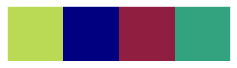

In [139]:
# To support both python 2 and python 3
from __future__ import division, print_function, unicode_literals

import numpy as np
import os
import pandas as pd
# To make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

import seaborn as sns
# set style of plots
sns.set_style('dark')

#define a custom palette
customPalette = ['#bada55', '#000080', '#901e40', '#33a27f']
sns.set_palette(customPalette)
sns.palplot(customPalette)


# Ignore useless warnings (see SciPy issue #5998)
import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")

In [140]:
# Import my spotify data
songs = pd.read_csv("deduplicated_tracks_from_my_playlists.csv", encoding = "latin-1")

songs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2918 entries, 0 to 2917
Data columns (total 18 columns):
added_at            2918 non-null object
name                2918 non-null object
artist              2918 non-null object
id                  2918 non-null object
popularity          2918 non-null int64
danceability        2918 non-null float64
energy              2918 non-null float64
loudness            2918 non-null float64
speechiness         2918 non-null float64
acousticness        2918 non-null float64
tempo               2918 non-null float64
liveness            2918 non-null float64
valence             2918 non-null float64
instrumentalness    2918 non-null float64
key                 2918 non-null int64
time_signature      2918 non-null int64
mode                2918 non-null int64
duration_ms         2918 non-null int64
dtypes: float64(9), int64(5), object(4)
memory usage: 410.5+ KB


In [141]:
songs = songs.drop('added_at', axis = 1)
songs.head()

,name,artist,id,popularity,danceability,energy,loudness,speechiness,acousticness,tempo,liveness,valence,instrumentalness,key,time_signature,mode,duration_ms
0,Saturdays (feat. HAIM),Twin Shadow,5ClqcvP4dYDDX6Zv3jPQD1,60,0.470,0.696,-4.749,0.1040,0.06590,169.976,0.0962,0.8020,0.000039,9,4,1,205442
1,Saint,Blood Orange,2PzWUwFXApjQBZzKMl4Hd6,56,0.795,0.629,-8.704,0.0745,0.04300,100.803,0.3780,0.0667,0.000154,5,4,0,192010
2,Everyone Acts Crazy Nowadays,Unknown Mortal Orchestra,6VPvz8SZWRFEoawyUTvQTt,51,0.816,0.755,-4.942,0.0828,0.47300,120.008,0.1780,0.7350,0.000003,8,4,1,254973
3,Less Is More,Choices,7MWJzAWFWT1ZSvf3D2dQrG,30,0.831,0.808,-5.002,0.0604,0.00635,121.994,0.2030,0.4900,0.314000,2,4,1,314754
4,Springtime,Ivana Parnasso,13FRCyzRG702n4PBpl0sot,2,0.792,0.577,-8.826,0.1160,0.16300,89.954,0.0476,0.6950,0.010300,1,4,1,268412


In [142]:
# to describe numerical features we can use describe()
songs.describe()

,popularity,danceability,energy,loudness,speechiness,acousticness,tempo,liveness,valence,instrumentalness,key,time_signature,mode,duration_ms
count,2918.000000,2918.000000,2918.000000,2918.000000,2918.000000,2918.000000,2918.000000,2918.000000,2918.000000,2918.000000,2918.000000,2918.000000,2918.000000,2.918000e+03
mean,36.180946,0.594897,0.614839,-8.310820,0.073753,0.269307,119.051086,0.180449,0.476206,0.128008,5.200480,3.925977,0.622344,2.475762e+05
std,22.914415,0.162993,0.214534,3.895897,0.083081,0.298538,27.216910,0.149654,0.246041,0.262880,3.582024,0.360936,0.484884,8.580904e+04
min,0.000000,0.000000,0.000076,-37.264000,0.000000,0.000004,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.480000e+03
25%,17.000000,0.492000,0.474000,-9.862750,0.034400,0.025400,99.935500,0.093925,0.278000,0.000004,2.000000,4.000000,0.000000,2.005045e+05
50%,40.000000,0.611000,0.640000,-7.518000,0.043800,0.134000,117.688000,0.121000,0.473000,0.000649,5.000000,4.000000,1.000000,2.324730e+05
75%,54.000000,0.711000,0.782000,-5.734250,0.072200,0.463750,133.969000,0.218000,0.670750,0.063000,8.000000,4.000000,1.000000,2.760768e+05
max,91.000000,0.975000,0.998000,1.342000,0.958000,0.996000,216.101000,0.974000,1.000000,0.992000,11.000000,5.000000,1.000000,1.395733e+06


The loudness feature is from -60db to 0 so we will normalise this column between 0 and 1.<br>
The tempo feature is in BPM so we will scale between 0 and 1 as well.

In [143]:
from sklearn import preprocessing

scaler = preprocessing.MinMaxScaler(feature_range=[0, 1])

loudness = songs[['loudness']].values
loudness_scaled = scaler.fit_transform(loudness)
songs['loudness'] = pd.DataFrame(loudness_scaled)

tempo = songs[['tempo']].values
tempo_scaled = scaler.fit_transform(tempo)
songs['tempo'] = pd.DataFrame(tempo_scaled)


songs.describe()

,popularity,danceability,energy,loudness,speechiness,acousticness,tempo,liveness,valence,instrumentalness,key,time_signature,mode,duration_ms
count,2918.000000,2918.000000,2918.000000,2918.000000,2918.000000,2918.000000,2918.000000,2918.000000,2918.000000,2918.000000,2918.000000,2918.000000,2918.000000,2.918000e+03
mean,36.180946,0.594897,0.614839,0.749966,0.073753,0.269307,0.550905,0.180449,0.476206,0.128008,5.200480,3.925977,0.622344,2.475762e+05
std,22.914415,0.162993,0.214534,0.100914,0.083081,0.298538,0.125945,0.149654,0.246041,0.262880,3.582024,0.360936,0.484884,8.580904e+04
min,0.000000,0.000000,0.000076,0.000000,0.000000,0.000004,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.480000e+03
25%,17.000000,0.492000,0.474000,0.709767,0.034400,0.025400,0.462448,0.093925,0.278000,0.000004,2.000000,4.000000,0.000000,2.005045e+05
50%,40.000000,0.611000,0.640000,0.770502,0.043800,0.134000,0.544597,0.121000,0.473000,0.000649,5.000000,4.000000,1.000000,2.324730e+05
75%,54.000000,0.711000,0.782000,0.816706,0.072200,0.463750,0.619937,0.218000,0.670750,0.063000,8.000000,4.000000,1.000000,2.760768e+05
max,91.000000,0.975000,0.998000,1.000000,0.958000,0.996000,1.000000,0.974000,1.000000,0.992000,11.000000,5.000000,1.000000,1.395733e+06


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001E937539F08>,
      dtype=object)

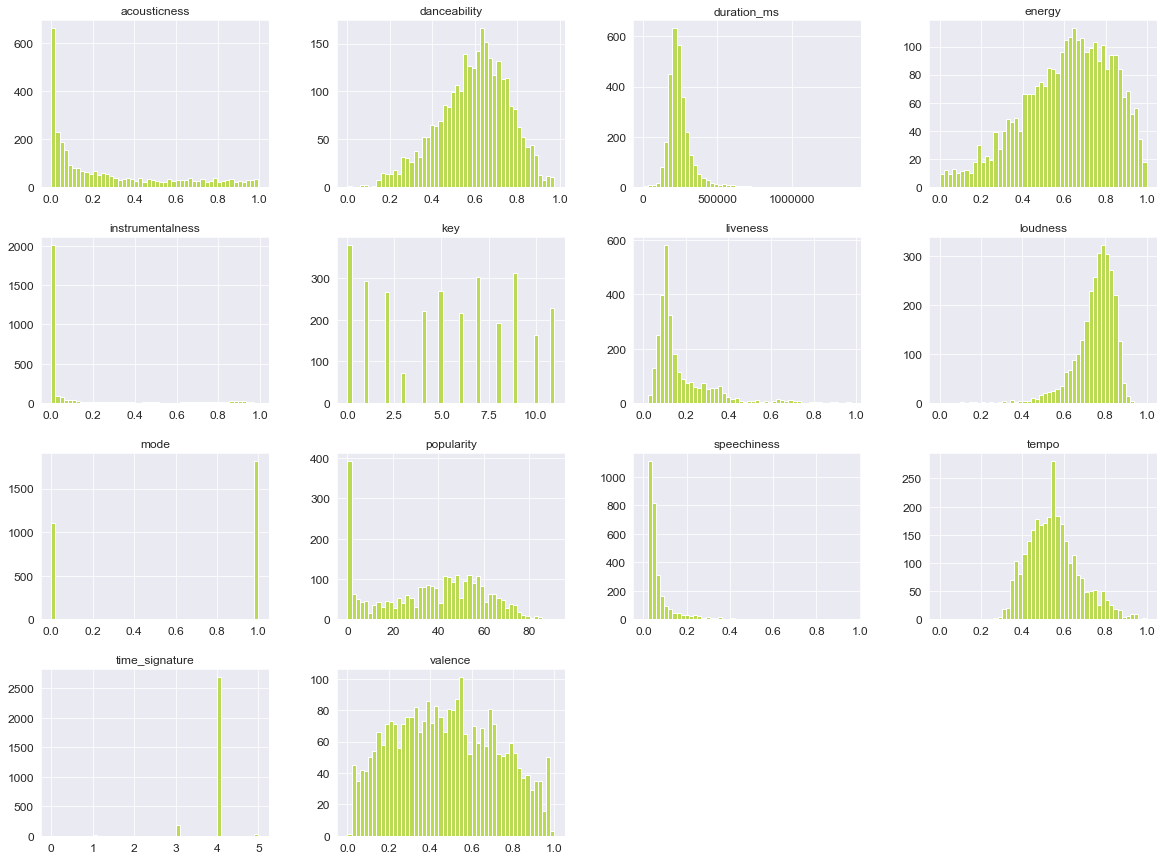

In [144]:
songs.hist(bins=50,figsize=(20,15))

Most features are skewed to the left or the right

In [145]:
# remove song names, artist, id and other features before clustering
songs_features = songs.copy()
songs_features = songs_features.drop(['name','artist','id', 'key', 'time_signature', 'mode', 'popularity', 'duration_ms'],axis=1)

songs_features.head()

,danceability,energy,loudness,speechiness,acousticness,tempo,liveness,valence,instrumentalness
0,0.470,0.696,0.842227,0.1040,0.06590,0.786558,0.0962,0.8020,0.000039
1,0.795,0.629,0.739781,0.0745,0.04300,0.466462,0.3780,0.0667,0.000154
2,0.816,0.755,0.837227,0.0828,0.47300,0.555333,0.1780,0.7350,0.000003
3,0.831,0.808,0.835673,0.0604,0.00635,0.564523,0.2030,0.4900,0.314000
4,0.792,0.577,0.736621,0.1160,0.16300,0.416259,0.0476,0.6950,0.010300


We removed, certain song attributes and popularity as we don't want these particular "features" of a song to influence our clusters

A PCA tutorial to assist in explaining PCA before leveraging it:<br>
https://towardsdatascience.com/an-approach-to-choosing-the-number-of-components-in-a-principal-component-analysis-pca-3b9f3d6e73fe

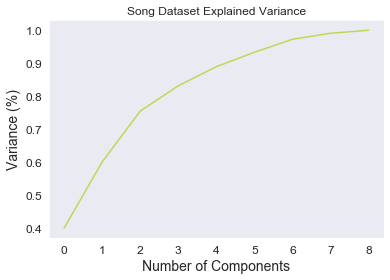

In [147]:
#Fitting the PCA algorithm with our Data
pca = PCA().fit(songs_features)
#Plotting the Cumulative Summation of the Explained Variance
plt.figure()
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Variance (%)') #for each component
plt.title('Song Dataset Explained Variance')
plt.show()


In [148]:
print(pca.explained_variance_ratio_.cumsum())

[0.3996506  0.60015744 0.75449185 0.83146819 0.8892751  0.93310375
 0.9725567  0.99077429 1.        ]


The explained variance tells you how much information (variance) can be attributed to each of the principal components. By looking at the cumulative sum of explained_variance_ratio_, we can see that 6 clusters will explain 97% of the variation that we see in our song data.

In [149]:
from sklearn.cluster import KMeans

sum_of_squared_distances = []
K = range(1, 15)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(songs_features)
    sum_of_squared_distances.append(km.inertia_)

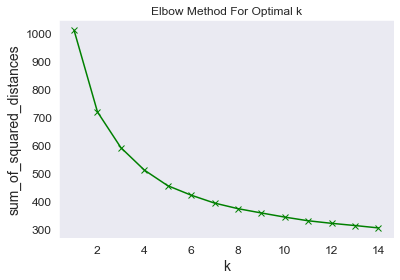

In [150]:
plt.plot(K, sum_of_squared_distances, 'gx-')
plt.xlabel('k')
plt.ylabel('sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

In [151]:
from sklearn.metrics import silhouette_score
for n_clusters in range(1, 7):
    clusterer = KMeans(n_clusters=n_clusters)
    preds = clusterer.fit_predict(songs_features)
    centers = clusterer.cluster_centers_
    # print('cluster:', clusterer)
    # print('preds:', preds)
    # print('centers:', centers)

The Silhouette Coefficient is calculated using the mean intra-cluster distance (a) and the mean nearest-cluster distance (b) for each sample. The Silhouette Coefficient for a sample is (b - a) / max(a, b). To clarify, b is the distance between a sample and the nearest cluster that the sample is not a part of. Note that Silhouette Coefficient is only defined if number of labels is 2 <= n_labels <= n_samples - 1.
Reference: https://scikit-learn.org/stable/modules/generated/sklearn.metrics.silhouette_score.html

The best value is 1 and the worst value is -1. Values near 0 indicate overlapping clusters. Negative values generally indicate that a sample has been assigned to the wrong cluster, as a different cluster is more similar.

In [152]:
score = silhouette_score(songs_features, preds, metric='euclidean')
print("For n_clusters = {}, silhouette score is {})".format(n_clusters, score))

For n_clusters = 6, silhouette score is 0.2169368004629449)


In [153]:
kmeans = KMeans(n_clusters = 6)
kmeans.fit(songs_features)


KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=6, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [154]:
# PCA to reduce our data to 2 dimensions for visualization
from sklearn.decomposition import PCA
y_kmeans = kmeans.predict(songs_features)
pca = PCA(n_components = 2)
principal_components = pca.fit_transform(songs_features)


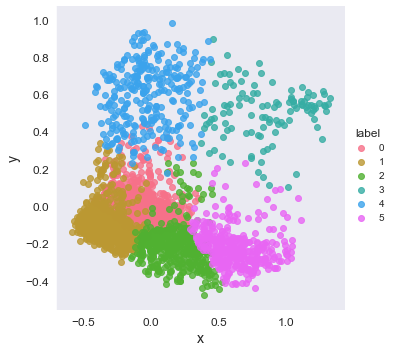

In [155]:
pc = pd.DataFrame(principal_components)
pc['label'] = y_kmeans
pc.columns = ['x', 'y','label']

#plot data with seaborn
cluster = sns.lmplot(data=pc, x='x', y='y', hue='label', 
                   fit_reg=False, legend=True, legend_out=True)

In [156]:
from sklearn.manifold import TSNE #T-Distributed Stochastic Neighbor Embedding
#T-SNE with two dimensions
tsne = TSNE(n_components = 2, perplexity = 50)

tsne_components = tsne.fit_transform(songs_features)

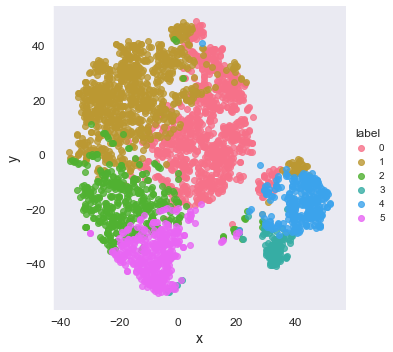

In [157]:
ts = pd.DataFrame(tsne_components)
ts['label'] = y_kmeans
ts.columns = ['x', 'y','label']

#plot data with seaborn
cluster = sns.lmplot(data=ts, x='x', y='y', hue='label', 
                   fit_reg=False, legend=True, legend_out=True)

We can also cluster using DBSCAN
<br>
With some assistance from: https://builtin.com/data-science/unsupervised-learning-python

In [158]:
from sklearn.cluster import DBSCAN

# Declaring Model
dbscan = DBSCAN(eps=0.3, min_samples=10)

# Fitting
dbscan.fit(songs_features)

DBSCAN(algorithm='auto', eps=0.3, leaf_size=30, metric='euclidean',
       metric_params=None, min_samples=10, n_jobs=None, p=None)

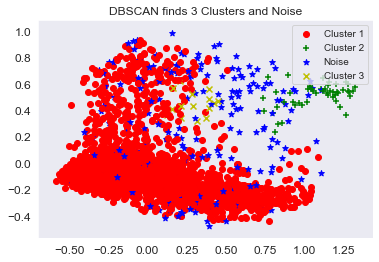

In [159]:
# Transforming Using PCA
pca = PCA(n_components = 6).fit(songs_features)
pca_2d = pca.transform(songs_features)

# Plot based on Class
for i in range(0, pca_2d.shape[0]):
    # print(dbscan.labels_[i])
    if dbscan.labels_[i] == 0:
        c1 = plt.scatter(pca_2d[i, 0], pca_2d[i, 1], c='r', marker='o')
    elif dbscan.labels_[i] == 1:
        c2 = plt.scatter(pca_2d[i, 0], pca_2d[i, 1], c='g', marker='+')
    elif dbscan.labels_[i] == -1:
        c3 = plt.scatter(pca_2d[i, 0], pca_2d[i, 1], c='b', marker='*')
    elif dbscan.labels_[i] == 2:
        c4 = plt.scatter(pca_2d[i, 0], pca_2d[i, 1], c='y', marker='x')

plt.legend([c1, c2, c3, c4], ['Cluster 1', 'Cluster 2', 'Noise', 'Cluster 3'])
plt.title('DBSCAN finds 3 Clusters and Noise')
plt.show()

In [160]:
# Dump components relations with features:
print (pd.DataFrame(pca.components_,columns=songs_features.columns,index = ['PC-1','PC-2', 'PC-3', 'PC-4', 'PC-5', 'PC-6']))

      danceability    energy  loudness  speechiness  acousticness     tempo  \
PC-1     -0.172169 -0.483990 -0.194268    -0.013608      0.716620 -0.064148   
PC-2     -0.098936  0.121665 -0.033206    -0.044422     -0.312798  0.043185   
PC-3      0.324476 -0.077197 -0.079593     0.024696      0.320665 -0.031396   
PC-4     -0.500005  0.441769  0.103851     0.025844      0.335464  0.185342   
PC-5      0.445361 -0.222885 -0.059222     0.130611     -0.118650 -0.378230   
PC-6     -0.368202 -0.604607 -0.293866    -0.018743     -0.374640  0.393510   

      liveness   valence  instrumentalness  
PC-1 -0.046462 -0.376828          0.190707  
PC-2  0.002955 -0.237715          0.903387  
PC-3 -0.060724  0.799601          0.367356  
PC-4  0.608676  0.156871          0.037416  
PC-5  0.745674 -0.133176          0.022553  
PC-6  0.208259  0.266694         -0.049655  


### Now let's explore the clusters and see what songs they contain

In [161]:
songs['label'] = y_kmeans

# shuffle dataset

songs = songs.sample(frac=1)
songs['label'].value_counts()

1    883
0    875
2    406
5    359
4    281
3    114
Name: label, dtype: int64

In [162]:
songs[songs['label'] == 0].head(40)

,name,artist,id,popularity,danceability,energy,loudness,speechiness,acousticness,tempo,liveness,valence,instrumentalness,key,time_signature,mode,duration_ms,label
882,Shout,Tears For Fears,2gQaQUhDCNGfBVXTvxAmXQ,70,0.511,0.942,0.695669,0.0429,0.174000,0.453071,0.1390,0.4980,0.000019,0,4,1,393667,0
1153,Flashing Lights,Kanye West,0ua0Go4NN4Td7l0Zre6Ce3,6,0.634,0.649,0.770839,0.0486,0.031500,0.418702,0.4820,0.5090,0.000000,6,4,0,237507,0
1528,Life Isn't Fair,Paul McMahon,7pu4hAp3TcYUO5NW86A9PA,0,0.498,0.423,0.717350,0.0298,0.081900,0.346407,0.0572,0.3710,0.000000,5,4,1,242733,0
1229,Level Tools (ANIMA! Remix),Yoke Lore,0T6niBwppU3jJYdnl4WVv0,38,0.708,0.579,0.770372,0.2680,0.139000,0.509077,0.3430,0.1920,0.000084,9,4,0,281455,0
1084,Moon In Water,Underworld,1L3AZIJzMvE08VvBkeFJvg,35,0.631,0.565,0.638372,0.0294,0.009140,0.532246,0.1250,0.4020,0.176000,5,4,1,342200,0
1279,Better - SG Lewis x Clairo,SG Lewis,32T61xmNSIXhGkEszzs0t8,62,0.699,0.583,0.713179,0.0357,0.050000,0.504398,0.0910,0.4840,0.000290,6,4,0,193762,0
2585,Boulevard of Broken Dreams (feat. John Gallagh...,Green Day,41pFyxOpS119Pb8JEzhx0w,59,0.417,0.647,0.813190,0.0296,0.056900,0.768715,0.0585,0.3390,0.000002,8,4,1,262387,0
2318,Andes Groove,Lechuga,2fjUwB0Rtz47lnMuXHlg0h,7,0.510,0.837,0.838523,0.0344,0.010200,0.509077,0.3620,0.4580,0.135000,1,1,0,278454,0
384,Misery,Soul Asylum,1uGht4m9AVY641N2DzoPpi,40,0.380,0.643,0.750142,0.0287,0.000049,0.526023,0.2440,0.2970,0.000027,0,4,1,264360,0
1620,Crave You - Adventure Club Remix,Flight Facilities,283LAlCpfArRZOXPfkOQj0,60,0.634,0.692,0.818992,0.0997,0.005860,0.647979,0.0726,0.0839,0.000116,1,4,0,236931,0


In [163]:
songs[songs['label']==0].mean()

popularity              36.270857
danceability             0.551170
energy                   0.677197
loudness                 0.785723
speechiness              0.071659
acousticness             0.094571
tempo                    0.567517
liveness                 0.192606
valence                  0.319705
instrumentalness         0.030322
key                      5.005714
time_signature           3.947429
mode                     0.610286
duration_ms         251306.330286
label                    0.000000
dtype: float64

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001E930E03288>,
      dtype=object)

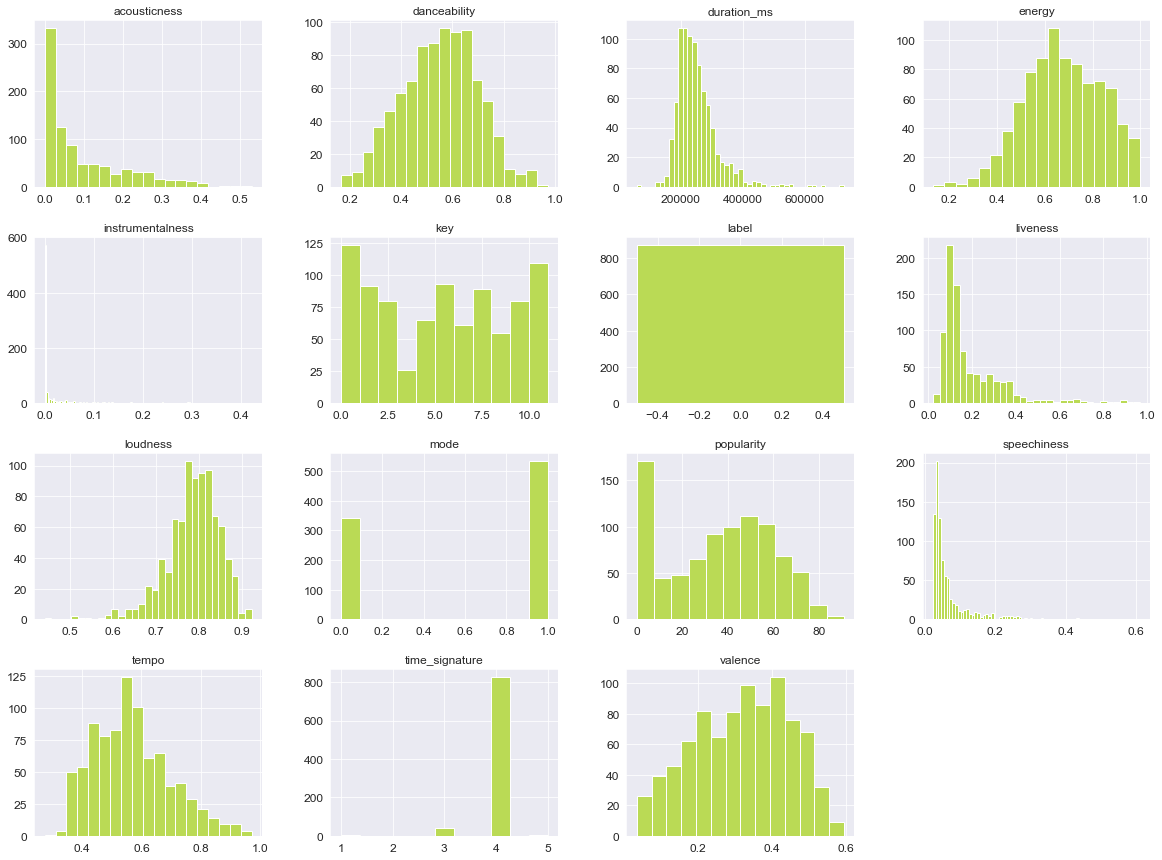

In [164]:
songs[songs['label']==0].hist(bins = 'auto', figsize=(20,15))

In [165]:
songs[songs['label']==1].head(40)

,name,artist,id,popularity,danceability,energy,loudness,speechiness,acousticness,tempo,liveness,valence,instrumentalness,key,time_signature,mode,duration_ms,label
2789,Stand On the Horizon,Franz Ferdinand,3eURsbRMwTuNqG0sqMxAWA,0,0.660,0.827,0.861239,0.0441,0.099600,0.570863,0.1150,0.576,0.000000,4,4,0,263120,1
2150,Drive,Incubus,7nnWIPM5hwE3DaUBkvOIpy,73,0.645,0.792,0.775113,0.0360,0.056200,0.419086,0.1190,0.666,0.012100,4,4,0,232453,1
438,Start Again (feat. Andrea Cormier),Pomo,43EsFRsE1oBbiVZn9Ewfem,10,0.594,0.791,0.805186,0.3320,0.025100,0.992665,0.0849,0.800,0.022400,7,4,0,246355,1
151,Cherry,Chromatics,71RPveF6c3dgG4tiljQw9K,57,0.656,0.784,0.799746,0.0354,0.033800,0.500900,0.1750,0.802,0.233000,7,4,0,271952,1
2886,Easy Way,For The Foxes,1nz9gtLzL5xC7fMU1MUlAp,22,0.551,0.798,0.801430,0.0430,0.256000,0.670825,0.1600,0.714,0.000345,7,4,0,267653,1
2183,Digging for Gold,Rag'n'Bone Man,5u6QsJUqstXyGwJNYxkgVn,30,0.568,0.750,0.795317,0.4110,0.113000,0.795929,0.3670,0.848,0.000000,5,4,0,268987,1
1145,Erotic City,Prince,0OfWbtiZ3fHd64VmpCSj7g,50,0.941,0.839,0.797985,0.1250,0.066300,0.580455,0.2420,0.763,0.011500,11,4,1,235493,1
2214,Love Me Iâm Famous,Gnarly Davidson,1fjas8lwknAnVJ5SCtuVhR,0,0.824,0.845,0.888411,0.1330,0.001590,0.462700,0.3270,0.634,0.000002,0,4,1,180677,1
200,Fun,Selena Gomez,65A5mkCzCAwcaI2LAFtral,48,0.863,0.419,0.702481,0.4370,0.076000,0.526911,0.1510,0.523,0.000049,11,4,0,189382,1
922,Spent the Day in Bed,Morrissey,1pkb7eplZ7xGrijYN0FyUh,51,0.612,0.598,0.787261,0.0276,0.007370,0.407296,0.1810,0.569,0.000098,1,4,1,211280,1


In [166]:
songs[songs['label']==1].mean()

popularity              39.533409
danceability             0.680975
energy                   0.737610
loudness                 0.793800
speechiness              0.079681
acousticness             0.093424
tempo                    0.558002
liveness                 0.183904
valence                  0.713732
instrumentalness         0.029447
key                      5.437146
time_signature           3.987542
mode                     0.609287
duration_ms         237886.070215
label                    1.000000
dtype: float64

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001E9376A6988>,
      dtype=object)

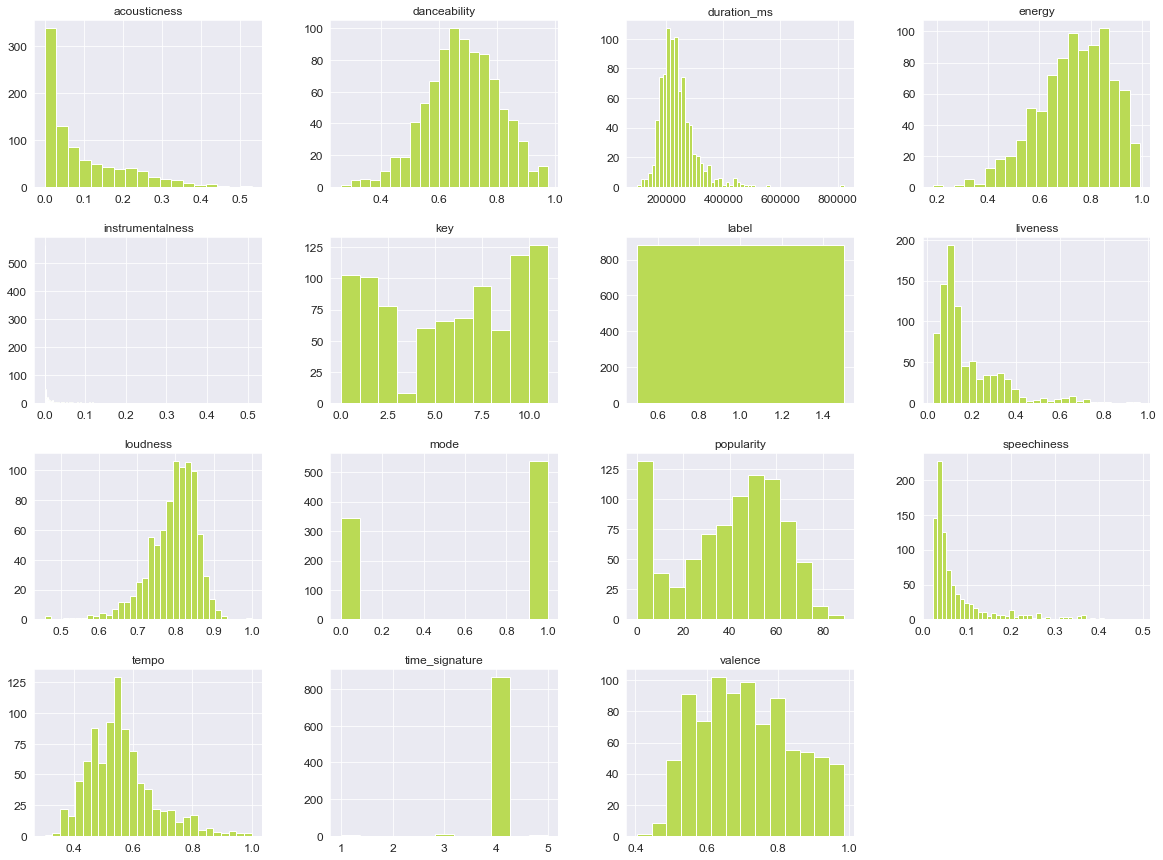

In [167]:
songs[songs['label']==1].hist(bins = 'auto', figsize=(20,15))

In [168]:
songs[songs['label']==2].head(40)

,name,artist,id,popularity,danceability,energy,loudness,speechiness,acousticness,tempo,liveness,valence,instrumentalness,key,time_signature,mode,duration_ms,label
2492,OlvÃ­dame y Pega la Vuelta - Tropical Version,Jennifer Lopez,1FLgluqbIigVOSc94mmAhU,37,0.624,0.826,0.872999,0.0832,0.502,0.759270,0.2010,0.640,0.000000,2,4,0,246525,2
1284,The Warriors,Snotty Nose Rez Kids,4Dwzmm8gnmQQGvZKzNUE9F,25,0.619,0.486,0.744185,0.3030,0.405,0.409202,0.1100,0.238,0.000001,9,4,1,253501,2
2765,Get Thy Bearings (feat. Szjerdene),Bonobo,4AojSWhrpehwehnGLwprAN,0,0.435,0.556,0.721390,0.0506,0.730,0.343261,0.2710,0.445,0.348000,4,4,0,185889,2
1718,All Around The World (feat. Desiigner & Chynna...,Mura Masa,4mIJOcVV9YcgwbiyZchhlB,28,0.821,0.456,0.754183,0.0412,0.427,0.610451,0.0752,0.383,0.000416,4,4,0,207760,2
1977,Renee,SALES,6V4Q1ZCVkj2cH2FLmigtsM,0,0.924,0.386,0.753277,0.0548,0.755,0.504195,0.1180,0.424,0.002530,9,4,1,179125,2
221,Time,Free Nationals,5ff2KcslMYqfxhI6GM2r3a,31,0.469,0.768,0.781485,0.3190,0.522,0.410017,0.0774,0.290,0.000181,5,4,1,210280,2
279,Lay Low,Neon Vines,7gOIaF8xsEkNMwFGJeKjDB,34,0.542,0.691,0.794229,0.0948,0.611,0.405167,0.1120,0.777,0.000209,1,4,1,244773,2
1559,Two Step,Ginger Root,3DKMwNvBajXJ6JHhrNEe1j,11,0.637,0.829,0.809745,0.0341,0.573,0.536754,0.1160,0.242,0.231000,7,4,0,175474,2
1890,The Look,Metronomy,3b4GWSS7QnzRKqH0mEYcFH,10,0.638,0.535,0.763405,0.0415,0.623,0.393089,0.0837,0.504,0.039100,9,4,0,277653,2
208,Just an Illusion,Imagination,4QT3YKobBj4BI7xCYRLr9u,59,0.752,0.549,0.692431,0.0328,0.295,0.486467,0.0582,0.658,0.115000,11,4,0,387867,2


In [169]:
songs[songs['label']==2].mean()

popularity              35.827586
danceability             0.643360
energy                   0.540438
loudness                 0.735355
speechiness              0.096840
acousticness             0.541729
tempo                    0.537434
liveness                 0.192695
valence                  0.572153
instrumentalness         0.033182
key                      5.019704
time_signature           3.958128
mode                     0.650246
duration_ms         223071.007389
label                    2.000000
dtype: float64

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001E9385CCE08>,
      dtype=object)

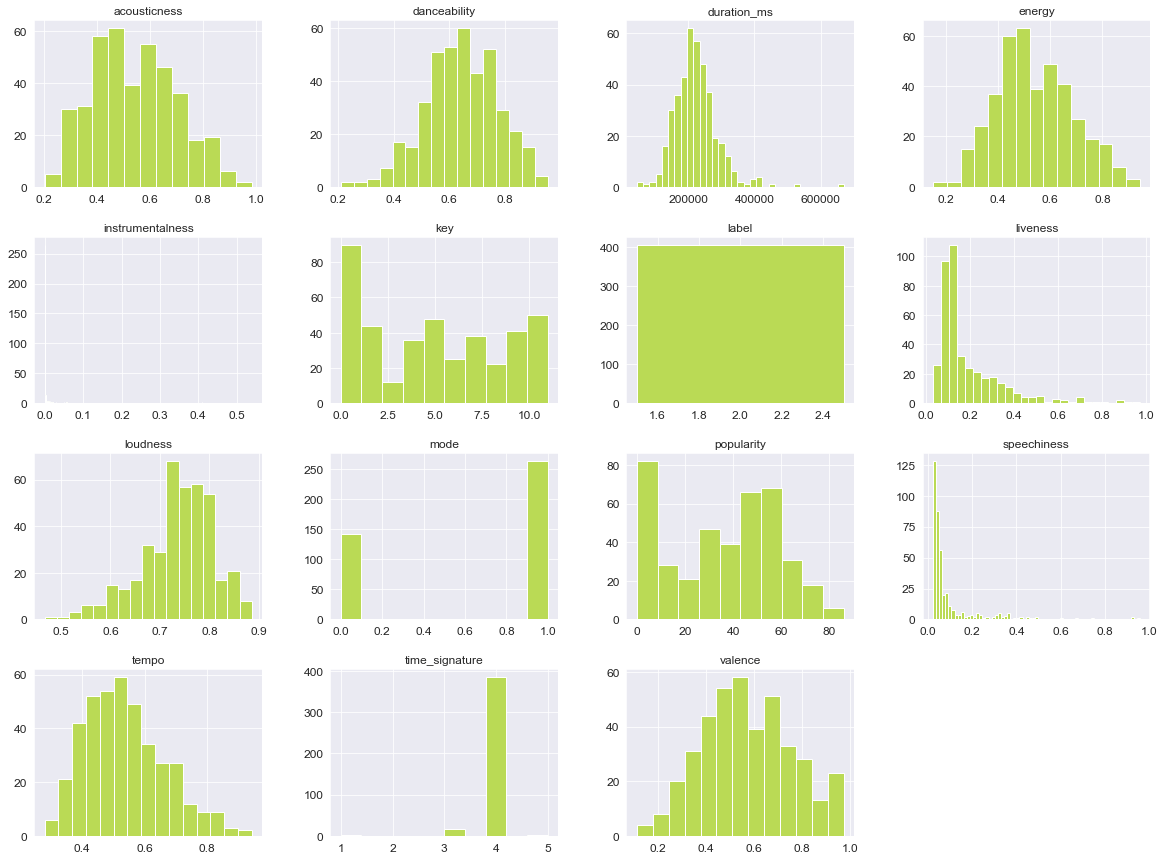

In [170]:
songs[songs['label']==2].hist(bins = 'auto', figsize=(20,15))

In [171]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils.multiclass import unique_labels

X = songs_features
y = y_kmeans

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)

rfc = RandomForestClassifier(n_estimators=100,criterion='gini')
rfc.fit(X_train,y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [172]:
# Predicting the Test set results
y_pred = rfc.predict(X_test)

In [173]:
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax


Confusion matrix, without normalization
[[278   7   0   0   1   0]
 [ 11 280   2   0   0   0]
 [  3   4 133   0   0   0]
 [  0   0   0  40   0   0]
 [  1   0   1   0  93   0]
 [  0   0   3   1   0 105]]


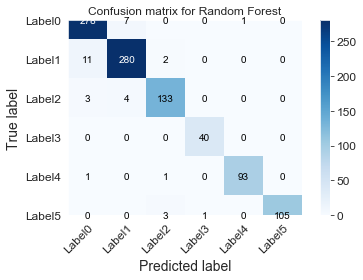

In [181]:
# Confusion matrix
definitions = ['Label0','Label1','Label2','Label3','Label4','Label5']
# reversefactor = dict(zip(range(4),definitions))
# actual = np.vectorize(reversefactor.get)(y_test)
# pred = np.vectorize(reversefactor.get)(y_pred)
# print(pd.crosstab(actual, pred, rownames=['Actual Mood'], colnames=['Predicted Mood']))

plot_confusion_matrix(y_test, y_pred, classes=definitions,
                      title='Confusion matrix for Random Forest')

In [182]:
# View a list of the features and their importance scores
features = songs_features.columns
list(zip(songs_features[features], rfc.feature_importances_))

[('danceability', 0.05566872806392931),
 ('energy', 0.09537419909770904),
 ('loudness', 0.04262862592540562),
 ('speechiness', 0.01668980497823807),
 ('acousticness', 0.24938877989317207),
 ('tempo', 0.01688986165908746),
 ('liveness', 0.015611457560063505),
 ('valence', 0.3122296970730627),
 ('instrumentalness', 0.19551884574933232)]

In [183]:
# View a list of the features and their importance scores
features = songs_features.columns
list(zip(songs_features[features], rfc.feature_importances_))

[('danceability', 0.05566872806392931),
 ('energy', 0.09537419909770904),
 ('loudness', 0.04262862592540562),
 ('speechiness', 0.01668980497823807),
 ('acousticness', 0.24938877989317207),
 ('tempo', 0.01688986165908746),
 ('liveness', 0.015611457560063505),
 ('valence', 0.3122296970730627),
 ('instrumentalness', 0.19551884574933232)]

In [184]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=3)
# Train the model using the training sets
knn.fit(X_train,y_train)


KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=3, p=2,
                     weights='uniform')

In [185]:
knn_pred = knn.predict(X_test)

Confusion matrix, without normalization
[[266  18   1   0   1   0]
 [ 16 273   3   0   1   0]
 [  3   9 123   0   0   5]
 [  0   0   1  38   0   1]
 [  2   0   1   2  90   0]
 [  3   0   6   0   0 100]]


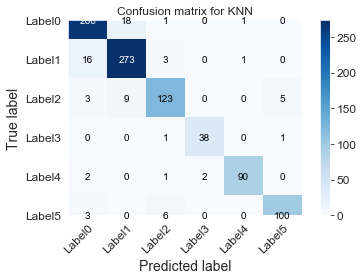

In [186]:
plot_confusion_matrix(y_test, knn_pred, classes=definitions,
                      title='Confusion matrix for KNN')

In [187]:
#Import svm model
from sklearn import svm
#Create a svm Classifier
svm = svm.SVC(kernel="linear") 

#Train the model using the training sets
svm.fit(X_train, y_train)

#Predict the response for test dataset
svm_pred = svm.predict(X_test)

Confusion matrix, without normalization
[[286   0   0   0   0   0]
 [  5 288   0   0   0   0]
 [  2   5 131   0   2   0]
 [  0   0   0  40   0   0]
 [  0   0   0   0  95   0]
 [  1   0   0   1   0 107]]


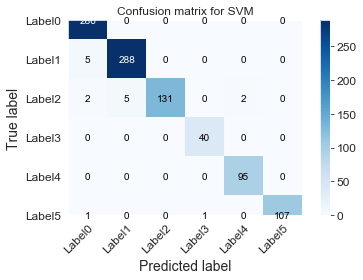

In [188]:
plot_confusion_matrix(y_test, svm_pred, classes=definitions,
                      title='Confusion matrix for SVM')

In [189]:
from sklearn.neural_network import MLPClassifier

In [190]:
mlp = MLPClassifier()
mlp.fit(X_train, y_train)

C:\Users\My Computer\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(100,), learning_rate='constant',
              learning_rate_init=0.001, max_iter=200, momentum=0.9,
              n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
              random_state=None, shuffle=True, solver='adam', tol=0.0001,
              validation_fraction=0.1, verbose=False, warm_start=False)

In [191]:
mlp_pred = mlp.predict(X_test)

Confusion matrix, without normalization
[[282   4   0   0   0   0]
 [  8 284   0   0   1   0]
 [  0   2 138   0   0   0]
 [  0   0   0  40   0   0]
 [  0   0   1   0  94   0]
 [  0   0   2   1   0 106]]


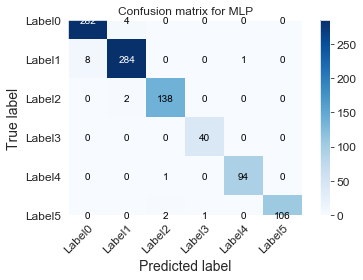

In [192]:
plot_confusion_matrix(y_test, mlp_pred, classes=definitions,
                      title='Confusion matrix for MLP')

In [193]:
print(classification_report(y_test,mlp_pred,target_names=definitions)+'MLP')

              precision    recall  f1-score   support

      Label0       0.97      0.99      0.98       286
      Label1       0.98      0.97      0.97       293
      Label2       0.98      0.99      0.98       140
      Label3       0.98      1.00      0.99        40
      Label4       0.99      0.99      0.99        95
      Label5       1.00      0.97      0.99       109

    accuracy                           0.98       963
   macro avg       0.98      0.98      0.98       963
weighted avg       0.98      0.98      0.98       963
MLP


In [194]:
print(classification_report(y_test,svm_pred,target_names=definitions)+'SVM')

              precision    recall  f1-score   support

      Label0       0.97      1.00      0.99       286
      Label1       0.98      0.98      0.98       293
      Label2       1.00      0.94      0.97       140
      Label3       0.98      1.00      0.99        40
      Label4       0.98      1.00      0.99        95
      Label5       1.00      0.98      0.99       109

    accuracy                           0.98       963
   macro avg       0.99      0.98      0.98       963
weighted avg       0.98      0.98      0.98       963
SVM


In [195]:
print(classification_report(y_test,knn_pred,target_names=definitions)+'KNN')

              precision    recall  f1-score   support

      Label0       0.92      0.93      0.92       286
      Label1       0.91      0.93      0.92       293
      Label2       0.91      0.88      0.89       140
      Label3       0.95      0.95      0.95        40
      Label4       0.98      0.95      0.96        95
      Label5       0.94      0.92      0.93       109

    accuracy                           0.92       963
   macro avg       0.94      0.93      0.93       963
weighted avg       0.92      0.92      0.92       963
KNN


In [196]:
print(classification_report(y_test,y_pred,target_names=definitions)+'forest')

              precision    recall  f1-score   support

      Label0       0.95      0.97      0.96       286
      Label1       0.96      0.96      0.96       293
      Label2       0.96      0.95      0.95       140
      Label3       0.98      1.00      0.99        40
      Label4       0.99      0.98      0.98        95
      Label5       1.00      0.96      0.98       109

    accuracy                           0.96       963
   macro avg       0.97      0.97      0.97       963
weighted avg       0.96      0.96      0.96       963
forest
